In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [41]:
from pathlib import Path
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score

from data_preparation_functions import *

## Data acquisition

In [3]:
def grab_epl_data():
    # Connect to football-data.co.uk
    res = requests.get("http://www.football-data.co.uk/englandm.php")

    # Create a BeautifulSoup object
    soup = BeautifulSoup(res.content, 'lxml')

    # Find the tables with the links to the data in them.
    table = soup.find_all('table', {'align': 'center', 'cellspacing': '0', 'width': '800'})[1]
    body = table.find_all('td', {'valign': 'top'})[1]

    # Grab the urls for the csv files
    links = [link.get('href') for link in body.find_all('a')]
    links_text = [link_text.text for link_text in body.find_all('a')]

    data_urls = []

    # Create a list of links
    prefix = 'http://www.football-data.co.uk/'
    for i, text in enumerate(links_text):
        if text == 'Premier League':
            data_urls.append(prefix + links[i])

    # Get rid of last 11 uls as these don't include match stats and odds, and we
    # only want from 2005 onwards
    data_urls = data_urls[:-12]

    df = pd.DataFrame()

    # Iterate over the urls
    for url in data_urls:
        # Get the season and make it a column
        season = url.split('/')[4]

        print(f"Getting data for season {season}")

        # Read the data from the url into a DataFrame
        temp_df = pd.read_csv(url)
        temp_df['season'] = season

        # Create helpful columns like Day, Month, Year, Date etc. so that our data is clean
        temp_df = (temp_df.dropna(axis='columns', thresh=temp_df.shape[0]-30)
                          .assign(Day=lambda df: df.Date.str.split('/').str[0],
                                  Month=lambda df: df.Date.str.split('/').str[1],
                                  Year=lambda df: df.Date.str.split('/').str[2])
                          .assign(Date=lambda df: df.Month + '/' + df.Day + '/' + df.Year)
                          .assign(Date=lambda df: pd.to_datetime(df.Date))
                          .dropna())

        # Append the temp_df to the main df
        df = df.append(temp_df, sort=True)

    # Drop all NAs
    df = df.dropna(axis=1).dropna().sort_values(by='Date')
    print("Finished grabbing data.")

    return df

In [4]:
df = grab_epl_data()

Getting data for season 1819
Getting data for season 1718
Getting data for season 1617
Getting data for season 1516
Getting data for season 1415
Getting data for season 1314
Getting data for season 1213
Getting data for season 1112
Getting data for season 1011
Getting data for season 0910
Getting data for season 0809
Getting data for season 0708
Getting data for season 0607
Getting data for season 0506
Finished grabbing data.


## Data exploration

In [5]:
df.head(5)

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Month,Referee,VCA,VCD,VCH,Year,season
7,6.0,14.0,1.0,11.0,5.0,1.0,Blackburn,2.75,3.20,2.50,2.90,3.30,2.20,55.0,20.0,0.00,1.71,2.02,2.74,2.04,1.82,3.16,2.40,1.80,2.25,2.90,2.08,1.86,3.35,2.60,35.0,2005-08-13,13,E0,1.0,3.0,H,2.0,11.0,0.0,13.0,5.0,1.0,0.0,A,0.0,West Ham,2.7,3.0,2.3,08,A Wiley,2.75,3.25,2.40,05,0506
0,8.0,16.0,0.0,13.0,6.0,2.0,Bolton,3.00,3.25,2.30,3.15,3.25,2.10,56.0,22.0,-0.25,1.70,2.01,3.05,1.84,2.01,3.16,2.20,1.87,2.20,3.40,1.92,2.10,3.30,2.40,36.0,2005-08-13,13,E0,2.0,2.0,D,7.0,14.0,0.0,3.0,2.0,2.0,2.0,D,0.0,Aston Villa,3.1,3.0,2.1,08,M Riley,3.10,3.25,2.20,05,0506
1,6.0,14.0,0.0,12.0,5.0,1.0,Man United,1.72,3.40,5.00,1.75,3.35,4.35,56.0,23.0,0.75,1.79,1.93,1.69,1.86,2.00,3.36,4.69,1.87,2.10,1.80,1.93,2.05,3.70,5.65,36.0,2005-08-13,13,E0,2.0,0.0,A,8.0,15.0,0.0,10.0,5.0,1.0,0.0,A,3.0,Everton,1.8,3.1,3.8,08,G Poll,1.80,3.30,4.50,05,0506
2,6.0,13.0,0.0,7.0,4.0,2.0,Birmingham,2.87,3.25,2.37,2.80,3.20,2.30,56.0,21.0,0.00,1.69,2.04,2.87,2.05,1.81,3.16,2.31,1.77,2.24,3.05,2.11,1.85,3.30,2.60,36.0,2005-08-13,13,E0,0.0,0.0,D,6.0,12.0,0.0,15.0,7.0,0.0,0.0,D,1.0,Fulham,2.9,3.0,2.2,08,R Styles,2.80,3.25,2.35,05,0506
3,6.0,11.0,0.0,13.0,3.0,3.0,West Brom,5.00,3.40,1.72,4.80,3.45,1.65,55.0,23.0,-0.75,1.77,1.94,4.79,1.76,2.10,3.38,1.69,1.90,2.10,5.60,1.83,2.19,3.63,1.80,36.0,2005-08-13,13,E0,0.0,0.0,D,3.0,13.0,0.0,15.0,8.0,0.0,0.0,D,2.0,Man City,4.2,3.2,1.7,08,C Foy,5.00,3.25,1.75,05,0506


### Home advantage?

In [6]:
# Create Home Win, Draw Win and Away Win columns
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

In [9]:
win_rates = \
(df.groupby('season')
    .mean()
    .loc[:, ['homeWin', 'draw', 'awayWin']])

win_rates

,homeWin,draw,awayWin
season,,,
0506,0.505263,0.202632,0.292105
0607,0.477573,0.258575,0.263852
0708,0.463158,0.263158,0.273684
0809,0.453826,0.255937,0.290237
0910,0.507895,0.252632,0.239474
1011,0.471053,0.292105,0.236842
1112,0.450000,0.244737,0.305263
1213,0.433862,0.285714,0.280423
1314,0.472973,0.208108,0.318919


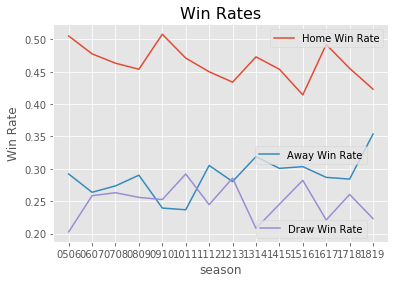

In [11]:
# Set the style
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)

home_line = ax.plot(win_rates.homeWin, label='Home Win Rate')
away_line = ax.plot(win_rates.awayWin, label='Away Win Rate')
draw_line = ax.plot(win_rates.draw, label='Draw Win Rate')
ax.set_xlabel("season")
ax.set_ylabel("Win Rate")
plt.title("Win Rates", fontsize=16)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.4))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.95, 0.06))

In [13]:
home_win_rates = \
(df.groupby(['HomeTeam'])
    .homeWin
    .mean())

away_win_rates = \
(df.groupby(['AwayTeam'])
    .awayWin
    .mean())

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)

In [14]:
hga.head(5)

,HomeTeam,HGA
15,Fulham,0.315646
7,Brighton,0.284615
20,Man City,0.247726
14,Everton,0.245813
30,Stoke,0.241131


In [15]:
big_clubs = ['Liverpool', 'Man City', 'Man United', 'Chelsea', 'Arsenal']
home_win_rates_5 = df[df.HomeTeam.isin(big_clubs)].groupby(['HomeTeam', 'season']).homeWin.mean()
away_win_rates_5 = df[df.AwayTeam.isin(big_clubs)].groupby(['AwayTeam', 'season']).awayWin.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

HomeTeam,Arsenal,Chelsea,Liverpool,Man City,Man United
season,,,,,
0506,0.421053,0.368421,0.263158,0.263158,0.052632
0607,0.263158,0.000000,0.421053,-0.052632,0.105263
0708,0.210526,-0.052632,0.157895,0.368421,0.368421
0809,0.105263,-0.157895,-0.052632,0.578947,0.210526
0910,0.368421,0.368421,0.421053,0.315789,0.263158
1011,0.157895,0.368421,0.368421,0.263158,0.684211
1112,0.157895,0.315789,-0.105263,0.421053,0.105263
1213,0.052632,0.105263,0.105263,0.248538,0.201754
1314,0.143275,0.251462,0.307018,0.362573,-0.026316


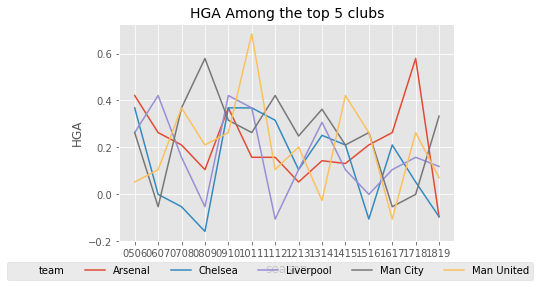

In [16]:
sns.lineplot(x='season', y='HGA', hue='team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'HomeTeam': 'team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)
plt.show()

/anaconda3/envs/btfair/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


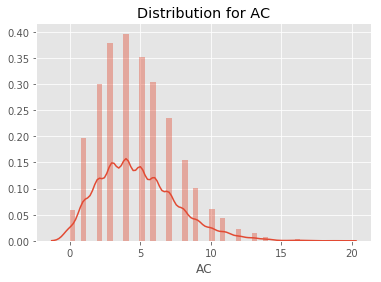

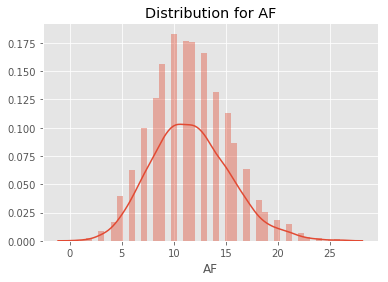

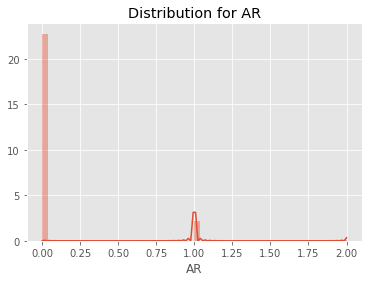

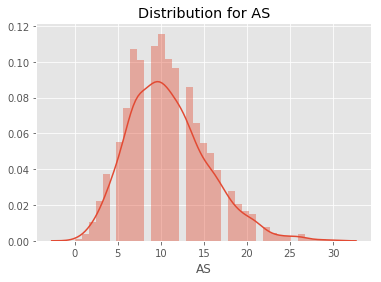

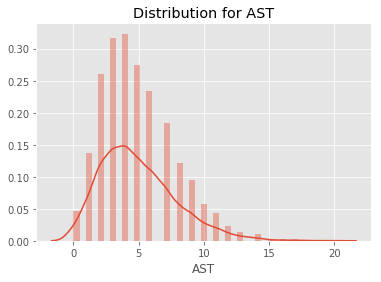

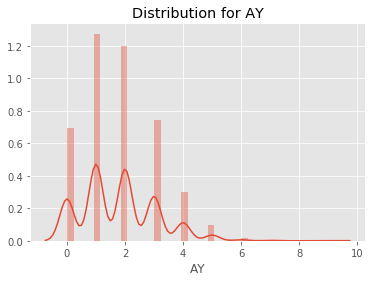

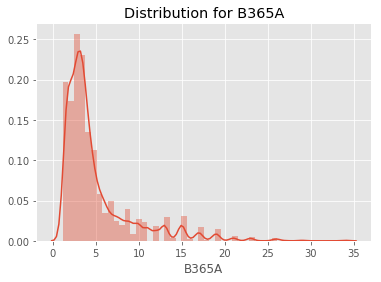

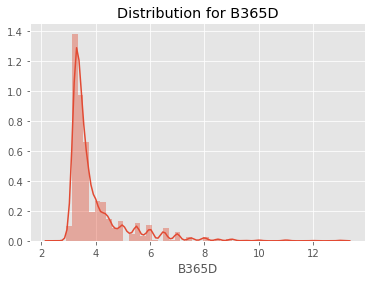

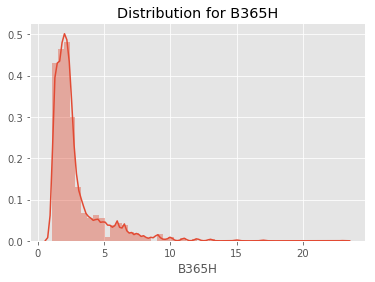

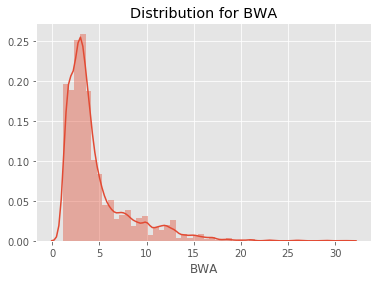

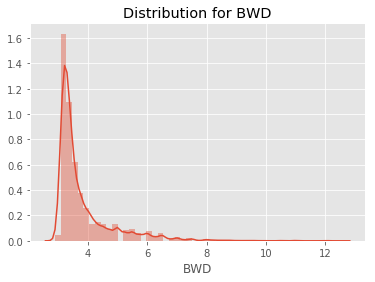

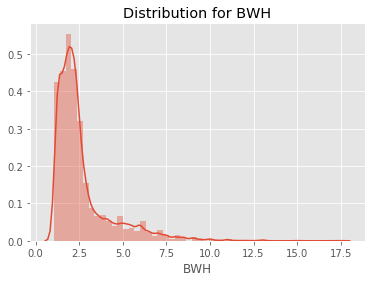

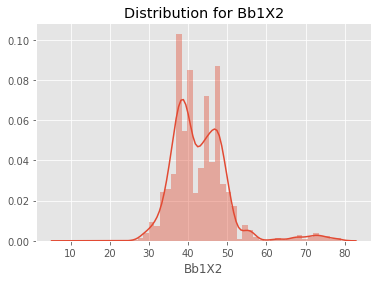

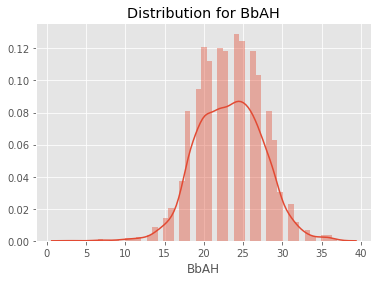

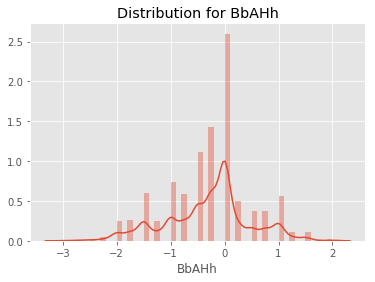

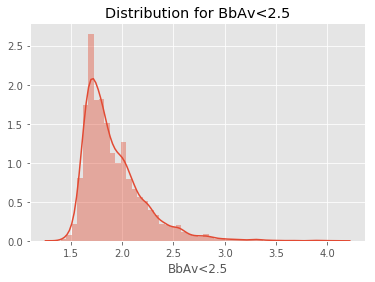

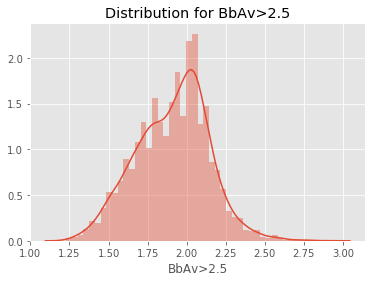

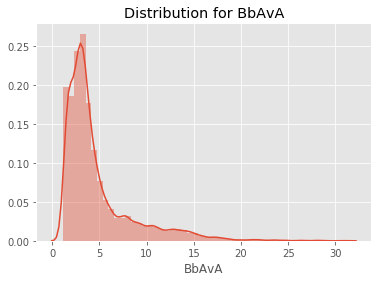

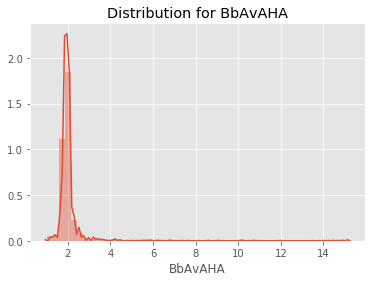

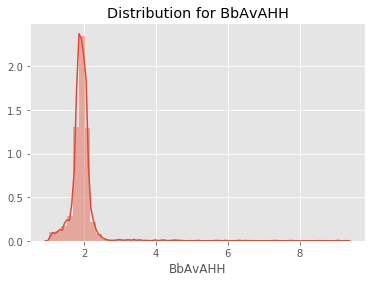

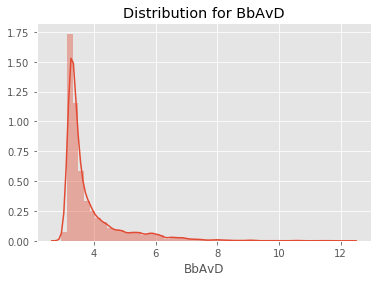

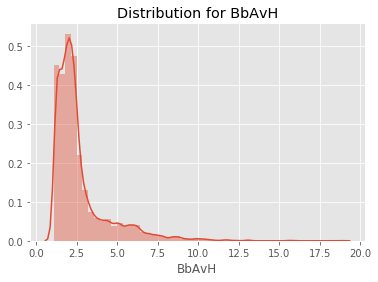

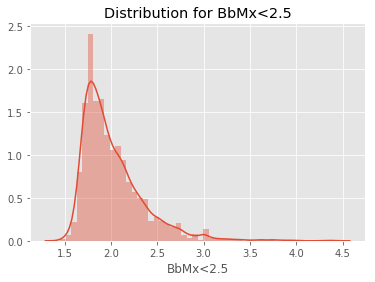

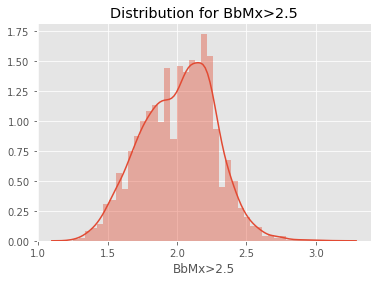

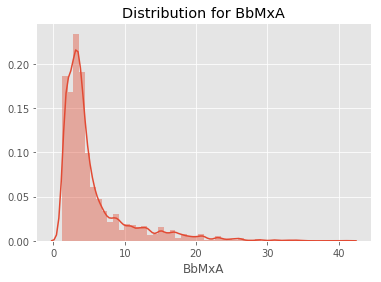

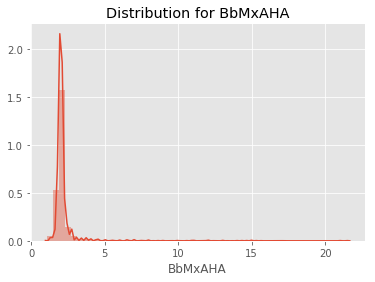

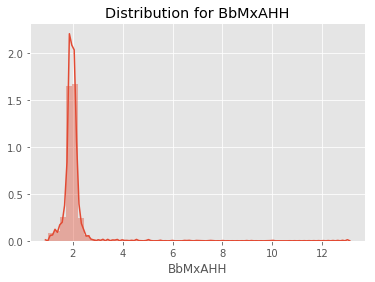

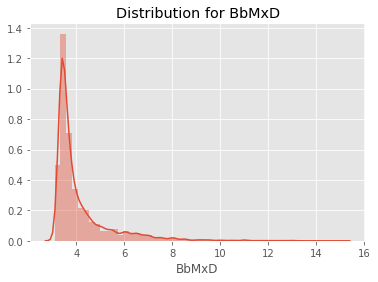

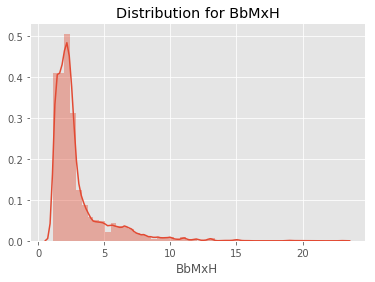

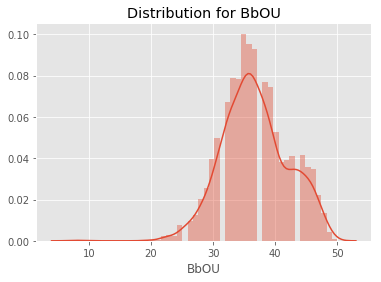

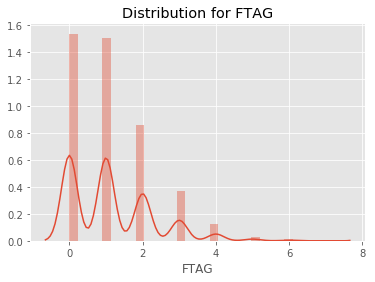

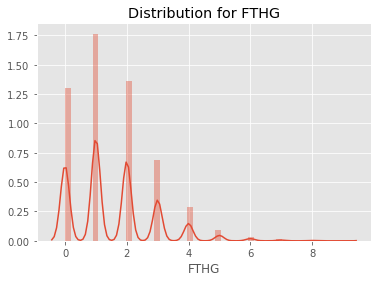

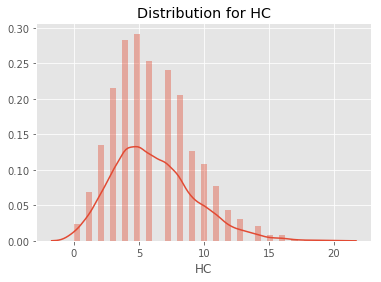

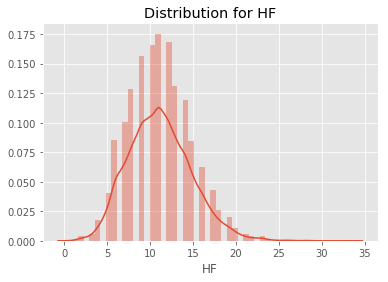

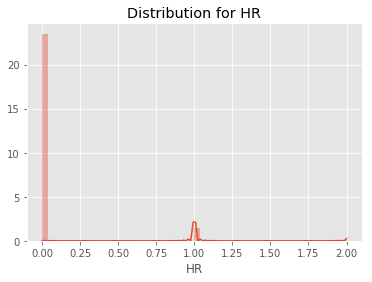

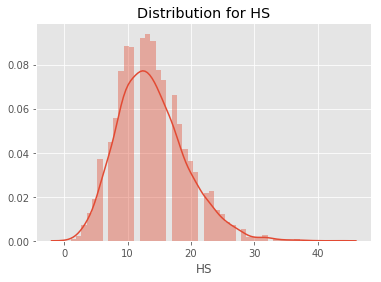

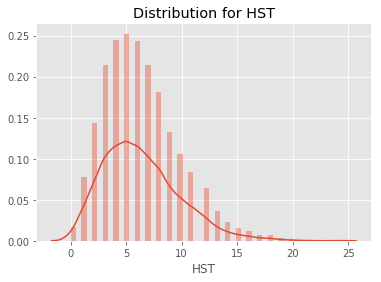

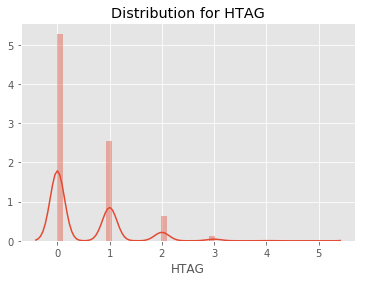

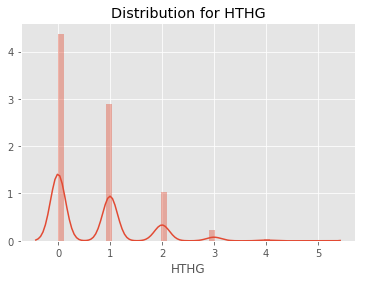

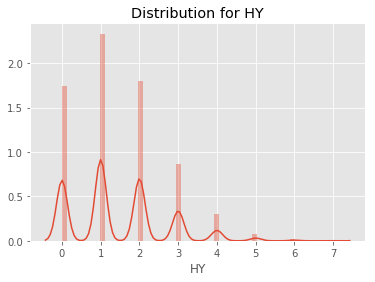

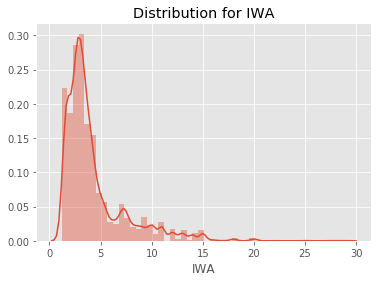

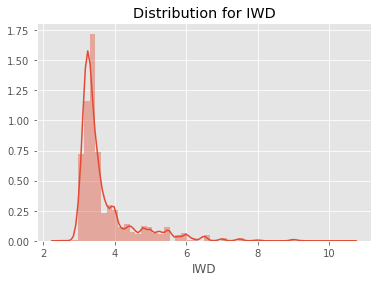

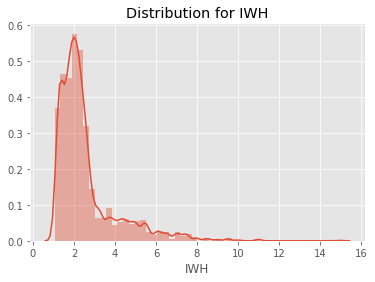

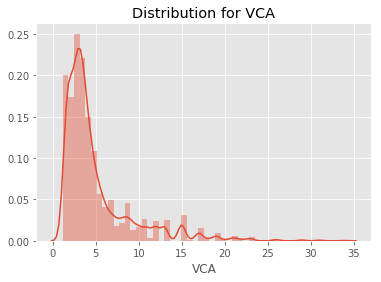

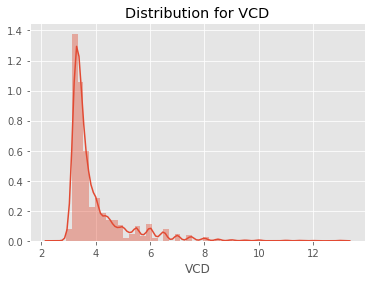

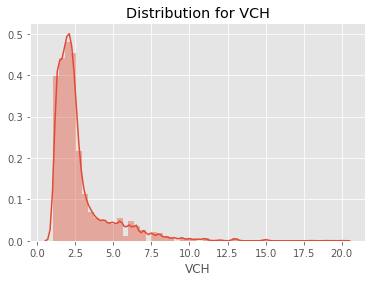

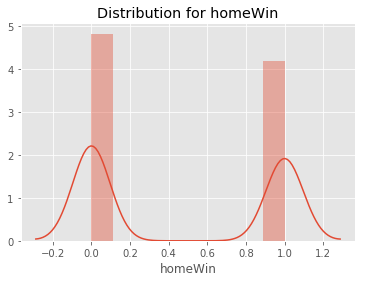

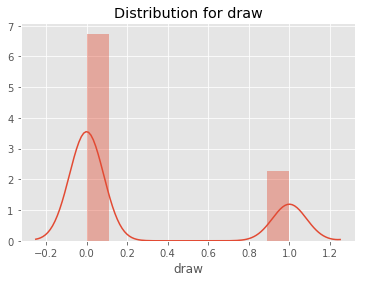

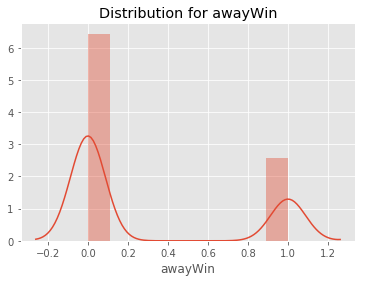

In [17]:
for col in df.select_dtypes('number').columns:
    sns.distplot(df[col])
    plt.title(f"Distribution for {col}")
    plt.show()

### Referee bias at home?

In [18]:
print('Overall Home Win Rate: {:.4}%'.format(df.homeWin.mean() * 100))

# Get the top 10 refs based on games
top_10_refs = df.Referee.value_counts().head(10).index

df[df.Referee.isin(top_10_refs)].groupby('Referee').homeWin.mean().sort_values(ascending=False)

Overall Home Win Rate: 46.44%


Referee
L Mason          0.510121
C Foy            0.500000
M Clattenburg    0.480000
P Dowd           0.469880
M Atkinson       0.463277
M Oliver         0.462617
H Webb           0.456604
A Marriner       0.448276
A Taylor         0.441748
M Dean           0.440633
Name: homeWin, dtype: float64

In [19]:
df['margin'] = df['FTHG'] - df['FTAG']

In [20]:
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'margin']

stat_correlations = df[stat_cols].corr()
stat_correlations['margin'].sort_values()

AST      -0.346085
AS       -0.299349
HY       -0.155087
HR       -0.130675
AC       -0.074344
HF       -0.066915
AF        0.006589
AY        0.015110
HC        0.068626
AR        0.100404
HS        0.277744
HST       0.369917
margin    1.000000
Name: margin, dtype: float64

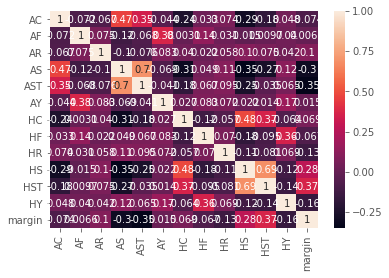

In [21]:
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 10})

## Feature analysis 

In [34]:
data_path = Path('data/')
data_path.mkdir(exist_ok=True)

In [38]:
# Create a cleaned df of all of our data

pre_features_df = create_df('data/epl_data.csv')

# Create our features
features = create_feature_df(pre_features_df)

Creating all games feature DataFrame
Creating stats feature DataFrame
Creating odds feature DataFrame
Creating market values feature DataFrame
Filling NAs
Merging stats, odds and market values into one features DataFrame
Complete.


In [39]:
features = (pre_features_df.assign(margin=lambda df: df.FTHG - df.FTAG)
                           .loc[:, ['gameId', 'margin']]
                           .pipe(pd.merge, features, on=['gameId']))

In [40]:
features.corr().margin.sort_values(ascending=False)[:20]

margin                     1.000000
f_awayOdds                 0.413893
f_totalMktH%               0.330420
f_defMktH%                 0.325392
f_eloAgainstAway           0.317853
f_eloForHome               0.317853
f_midMktH%                 0.316080
f_attMktH%                 0.312262
f_sizeOfHandicapAway       0.301667
f_goalsForHome             0.298930
f_wtEloGoalsForHome        0.297157
f_shotsForHome             0.286239
f_cornersForHome           0.279917
f_gkMktH%                  0.274732
f_homeWinPc38Away          0.271326
f_homeWinPc38Home          0.271326
f_wtEloGoalsAgainstAway    0.269663
f_goalsAgainstAway         0.258418
f_cornersAgainstAway       0.257148
f_drawOdds                 0.256807
Name: margin, dtype: float64

In [ ]:
## 